In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
import warnings

In [2]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [3]:
# Custom helper functions
from helper_functions import evaluate_model

In [4]:
def plot(data, cols):
  # plot the time series data
  plt.figure(figsize=(15, 6))
  plt.plot(data[cols[0]], data[cols[1]])
  plt.title('TSF')
  plt.xlabel(cols[0])
  plt.ylabel(cols[1])
  plt.show()

In [5]:
def plot_model_results(train, test, forecast, forecast_train, label, cols):
    # Plot Exponential Smoothing results
    plt.figure(figsize=(15, 6))
    plt.plot(train[cols[0]], train[cols[1]], label="Train", color='blue')
    plt.plot(test[cols[0]], test[cols[1]], label="Test", color='green')
    plt.plot(train[cols[0]], forecast_train, label='In-sample Forecast', color='red')
    plt.plot(
        test[cols[0]],
        forecast,
        label=label,
        color="orange",
    )
    plt.legend(loc="best")
    plt.show()

# Data: AMD Stock price

In [6]:
# Load dataset
loaded_data = pd.read_csv('amd.csv')

In [7]:
loaded_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,66.000000,66.879997,63.590000,64.019997,64.019997,46851800
1,2023-01-04,65.000000,65.790001,63.310001,64.660004,64.660004,47477100
2,2023-01-05,64.150002,64.349998,62.299999,62.330002,62.330002,46159500
3,2023-01-06,63.150002,64.300003,60.049999,63.959999,63.959999,70161300
4,2023-01-09,66.220001,69.320000,65.669998,67.239998,67.239998,69741300
...,...,...,...,...,...,...,...
311,2024-04-01,180.100006,187.240005,179.899994,183.339996,183.339996,74299900
312,2024-04-02,179.470001,180.100006,174.830002,178.699997,178.699997,61598800
313,2024-04-03,177.539993,182.050003,176.699997,180.770004,180.770004,49835100
314,2024-04-04,182.919998,183.020004,165.649994,165.830002,165.830002,88280000


In [8]:
loaded_data['date'] = pd.to_datetime(loaded_data['Date'])

In [9]:
# rename 'Adj Close' to 'price'
loaded_data.rename(columns={'Adj Close': 'price'}, inplace=True)

In [10]:
cols = ['date', 'price']
# cols = ['date', 'money']

# only keep the columns that we need
data = loaded_data[cols]
data = data.set_index(cols[0])

In [11]:
full_date_range = pd.date_range(start=data.index.min(), end=data.index.max())

In [12]:
data = data.reindex(full_date_range)

In [13]:
# fill missing values using linear interpolation
data.interpolate(method='linear', inplace=True)
# data.fillna(method='ffill', inplace=True)
data.index.name = 'date'
data.reset_index(inplace=True)

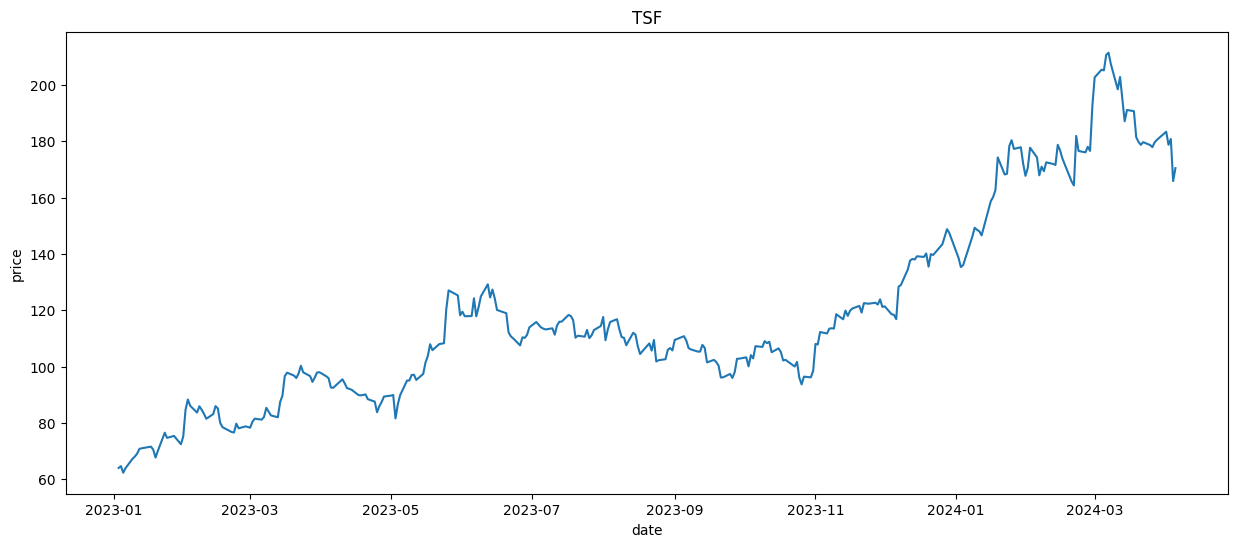

In [14]:
plot(data, cols)

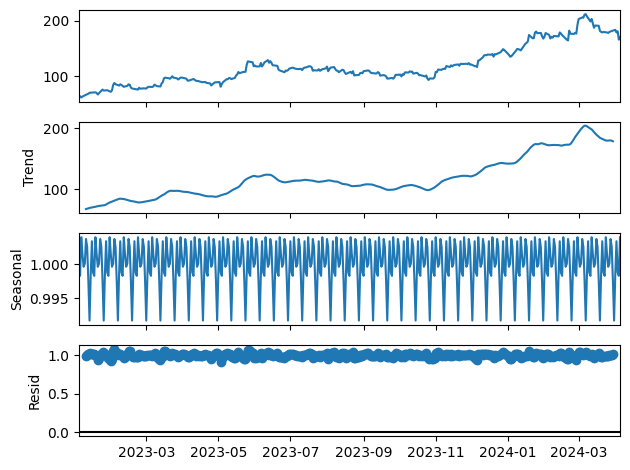

In [15]:
# seasonal decompose
result = seasonal_decompose(data.set_index('date'), model='multiplicative', period=12)
result.plot()
plt.show()

## Testing the need for differencing by using the Augmented Dickey-Fuller test

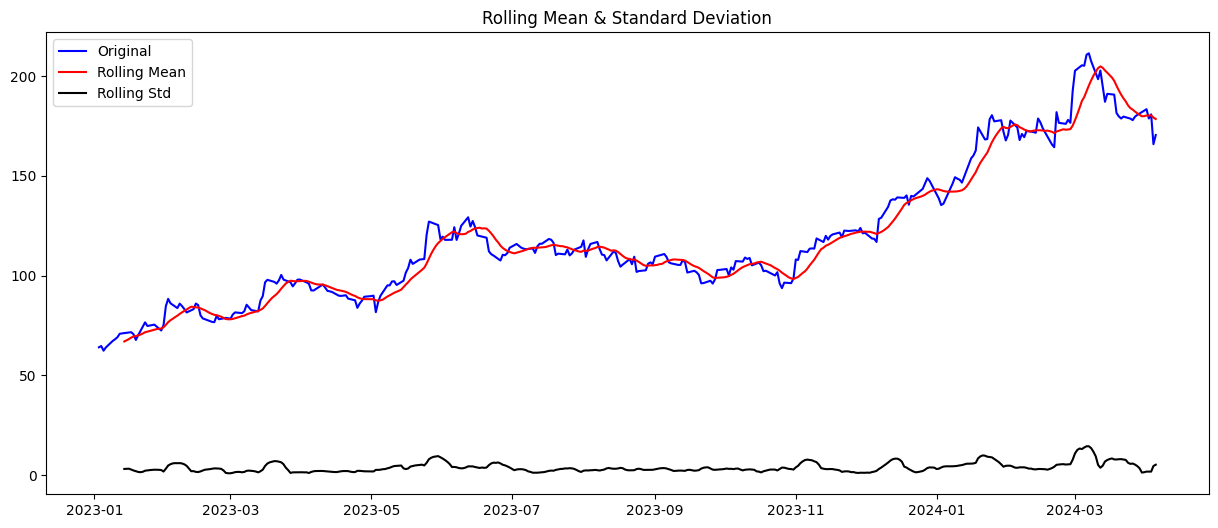

Results of Dickey-Fuller Test:
Test Statistic                  -0.979027
p-value                          0.760837
#Lags Used                       0.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [16]:
# stationary test
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15, 6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data.set_index(cols[0])[cols[1]])

## Differencing because p-value is greater than 0.05

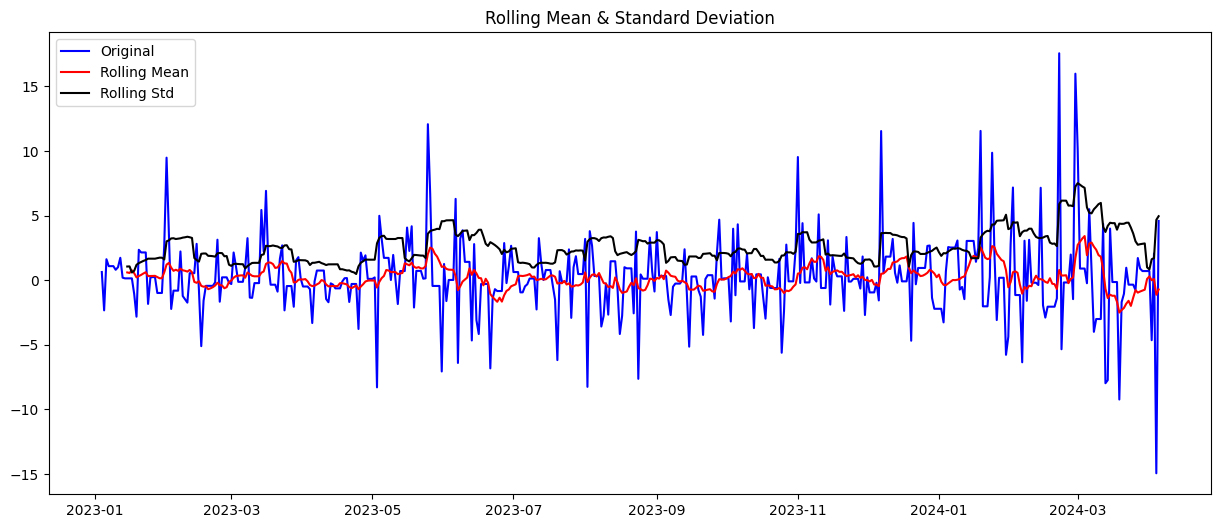

Results of Dickey-Fuller Test:
Test Statistic                 -20.772209
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    457.000000
Critical Value (1%)             -3.444740
Critical Value (5%)             -2.867885
Critical Value (10%)            -2.570150
dtype: float64


In [17]:
# the data is not stationary, we need to apply differencing
data['price_diff'] = data['price'] - data['price'].shift(1)
data.dropna(inplace=True)
test_stationarity(data.set_index('date')['price_diff'])
# cols = ['price_diff', cols[1]]

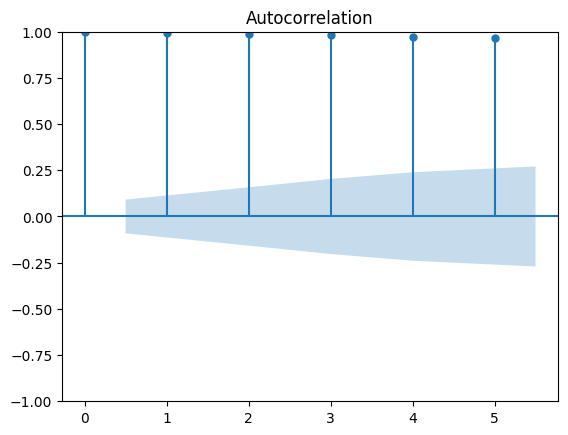

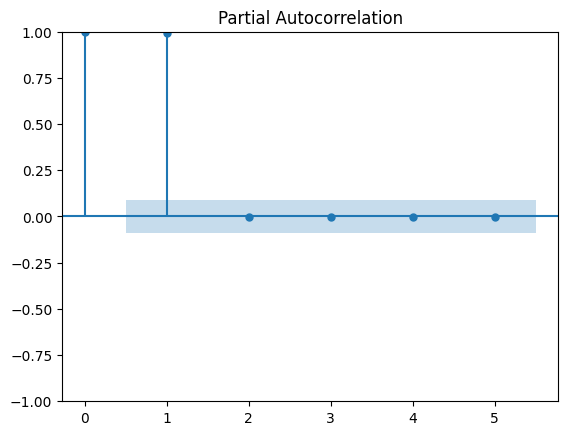

In [18]:
# generate ACF and PACF plots to determine the order of ARIMA model
col = cols[0]
plot_acf(data[col], lags=5)
plot_pacf(data[col], lags=5)
plt.show()

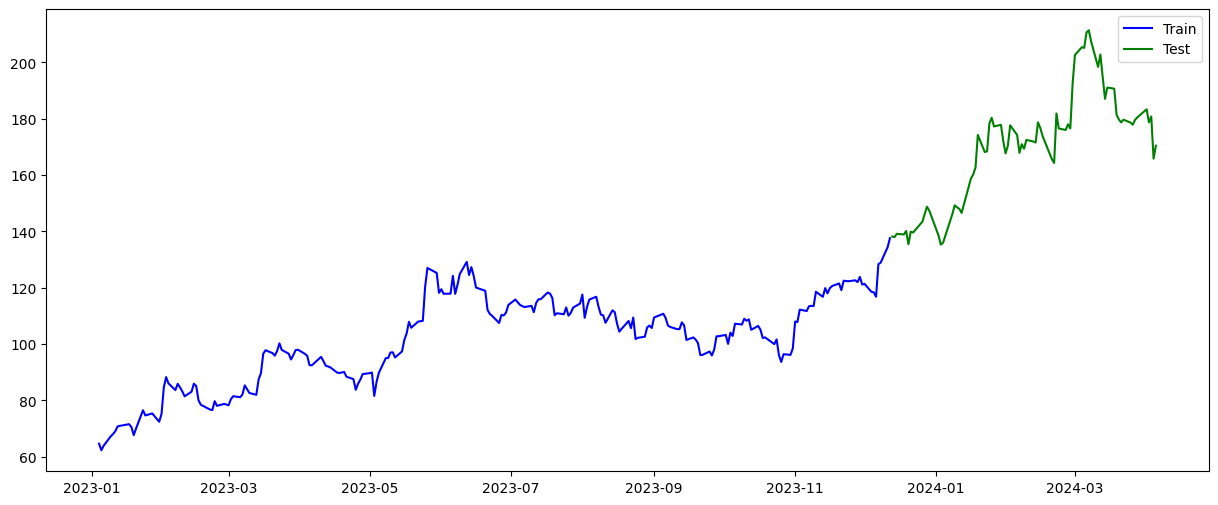

In [19]:
# train test split
train_size = int(len(data) * 0.75)
train, test = data[:train_size], data[train_size:]

# plot train and test data (with different colors - blue for train and green for test)
plt.figure(figsize=(15, 6))
plt.plot(train[cols[0]], train[cols[1]], label='Train', color='blue')
plt.plot(test[cols[0]], test[cols[1]], label='Test', color='green')
plt.legend(loc='best')
plt.show()

# Exponential Smoothing

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


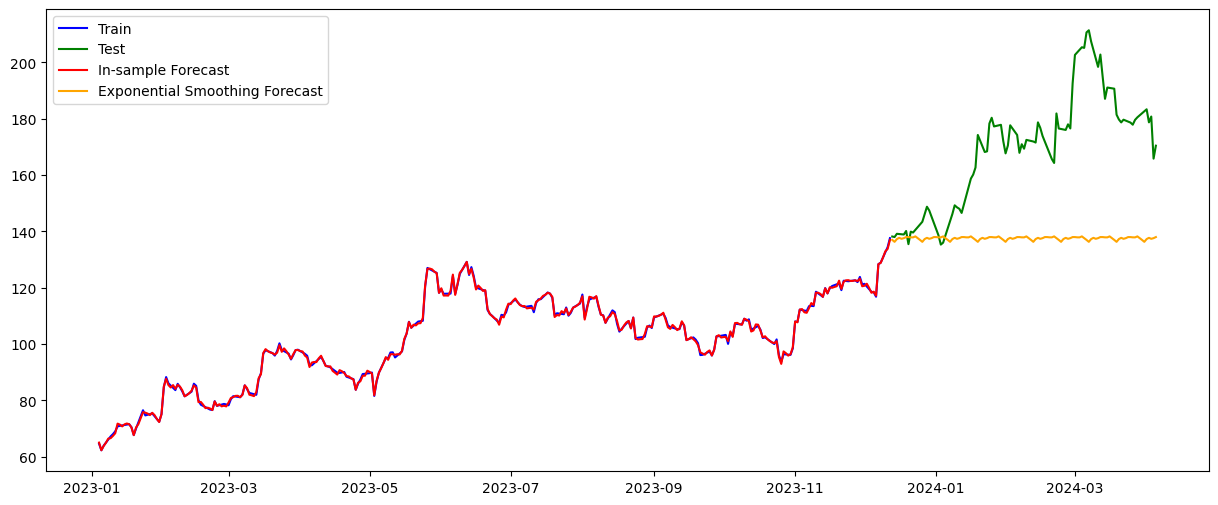

In [20]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Exponential Smoothing
model_es = ExponentialSmoothing(
    train[cols[1]], seasonal="add", seasonal_periods=12
).fit()
forecast_es = model_es.forecast(len(test))
# predict in sample (train data)
forecast_train_es = model_es.predict(start=train.index[0], end=train.index[-1])

plot_model_results(
    train=train,
    test=test,
    label="Exponential Smoothing Forecast",
    forecast=forecast_es,
    forecast_train=forecast_train_es,
    cols=cols,
)

# AR: Autoregression

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


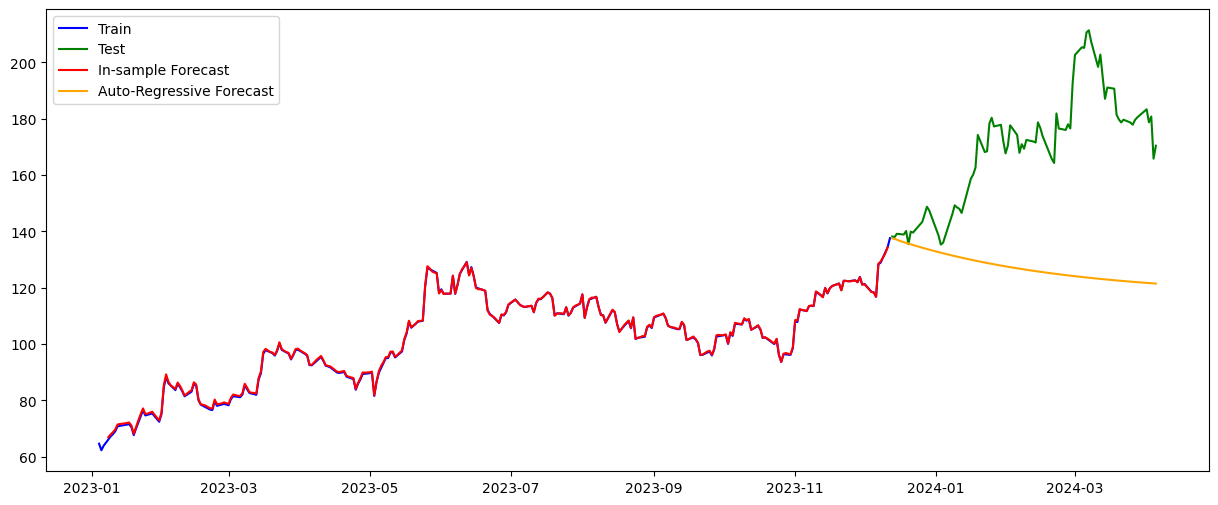

In [21]:
from statsmodels.tsa.ar_model import AutoReg

# Auto-Regressive Model
model_ar = AutoReg(train[cols[1]], lags=5).fit()
forecast_ar = model_ar.forecast(steps=len(test))
# predict in sample (train data)
forecast_train_ar = model_ar.predict(start=0, end=len(train) - 1)

plot_model_results(
    train=train,
    test=test,
    label="Auto-Regressive Forecast",
    forecast=forecast_ar,
    forecast_train=forecast_train_ar,
    cols=cols,
)

# MA: Moving Average

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


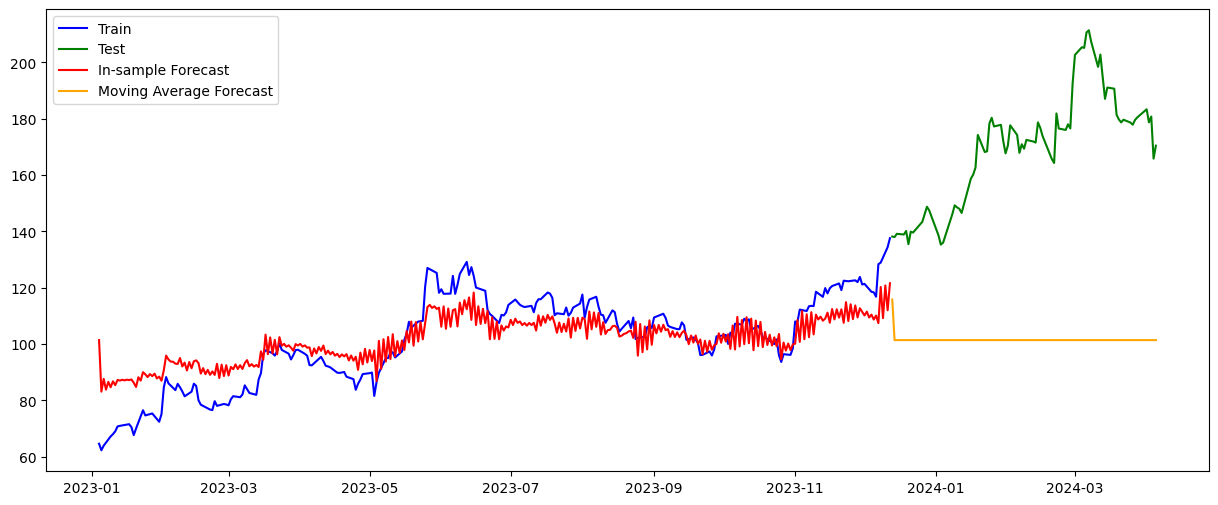

In [22]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an MA(1) model (ARIMA(0, 0, 1))
model_ma = ARIMA(train[cols[1]], order=(0, 0, 1)).fit()
forecast_ma = model_ma.forecast(steps=len(test))
# predict in sample (train data)
forecast_train_ma = model_ma.predict(start=0, end=len(train) - 1, typ='levels')

plot_model_results(
    train=train,
    test=test,
    label="Moving Average Forecast",
    forecast=forecast_ma,
    forecast_train=forecast_train_ma,
    cols=cols,
)

# ARIMA

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


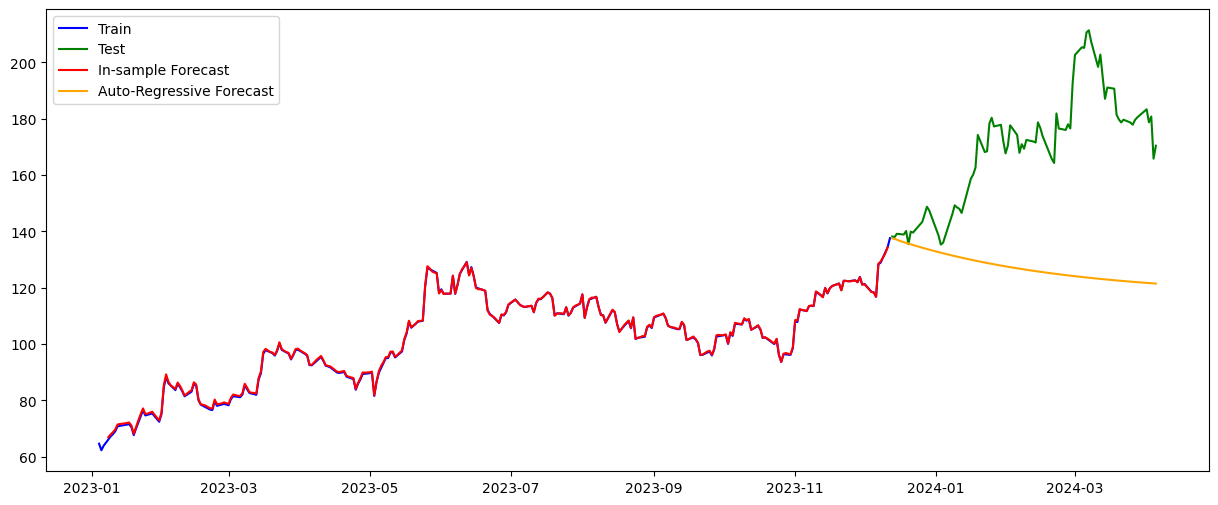

In [23]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA Model
model_arima = ARIMA(train[cols[1]], order=(1, 1, 1)).fit()
forecast_arima = model_arima.forecast(steps=len(test))
# predict in sample (train data)
forecast_train_arima = model_arima.predict(start=0, end=len(train) - 1, typ='levels')

plot_model_results(
    train=train,
    test=test,
    label="Auto-Regressive Forecast",
    forecast=forecast_ar,
    forecast_train=forecast_train_ar,
    cols=cols,
)

# SARIMA

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35140D+00    |proj g|=  1.17322D-01

At iterate    5    f=  2.26715D+00    |proj g|=  2.35090D-02


 This problem is unconstrained.



At iterate   10    f=  2.26099D+00    |proj g|=  1.23679D-03

At iterate   15    f=  2.26063D+00    |proj g|=  2.49008D-03

At iterate   20    f=  2.26049D+00    |proj g|=  3.31577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     25      1     0     0   1.497D-05   2.260D+00
  F =   2.2604921324881606     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


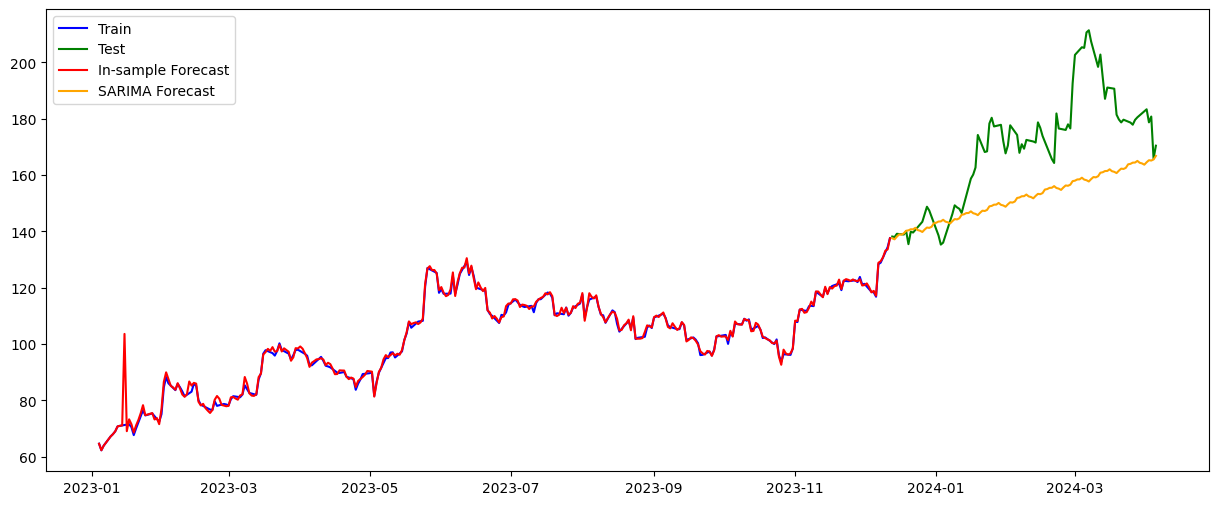

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA Model
model_sarima = SARIMAX(train[cols[1]], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
forecast_sarima = model_sarima.forecast(steps=len(test))
# predict in sample (train data)
forecast_sarima_train = model_sarima.predict(start=train.index.min(), end=train.index.max())

plot_model_results(
  train=train,
  test=test,
  label="SARIMA Forecast",
  forecast=forecast_sarima,
  forecast_train=forecast_sarima_train,
  cols=cols,
)

In [28]:
rmse_es, mae_es, r2_es, mape_es = evaluate_model(test[cols[1]], forecast_es)
rmse_ar, mae_ar, r2_ar, mape_ar = evaluate_model(test[cols[1]], forecast_ar)
rmse_ma, mae_ma, r2_ma, mape_ma = evaluate_model(test[cols[1]], forecast_ma)
rmse_arima, mae_arima, r2_arima, mape_arima = evaluate_model(
    test[cols[1]], forecast_arima
)
rmse_sarima, mae_sarima, r2_sarima, mape_sarima = evaluate_model(
    test[cols[1]], forecast_sarima
)

print(f"ES: RMSE={rmse_es}, MAE={mae_es} R2={r2_es} MAPE={mape_es}")
print(f"AR: RMSE={rmse_ar}, MAE={mae_ar} R2={r2_ar} MAPE={mape_ar}")
print(f"MA: RMSE={rmse_ma}, MAE={mae_ma} R2={r2_ar} MAPE={mape_ar}")
print(f"ARIMA: RMSE={rmse_arima}, MAE={mae_arima} R2={r2_ar} MAPE={mape_ar}")
print(f"SARIMA: RMSE={rmse_sarima}, MAE={mae_sarima} R2={r2_ar} MAPE={mape_ar}")

ES: RMSE=37.606905192486856, MAE=31.847784526476786 R2=-2.4672404312543588 MAPE=0.17634455131693383
AR: RMSE=48.296375329856126, MAE=41.763022440961926 R2=-4.718443620688535 MAPE=0.232605444421265
MA: RMSE=70.73981400207006, MAE=67.7247079394962 R2=-4.718443620688535 MAPE=0.232605444421265
ARIMA: RMSE=37.26692591091061, MAE=31.445333227258015 R2=-4.718443620688535 MAPE=0.232605444421265
SARIMA: RMSE=22.431787562209276, MAE=17.971663686597502 R2=-4.718443620688535 MAPE=0.232605444421265
